# Simulation plots

In [1]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt
import pandas as pd
import ast
import re

In [2]:
centers = pd.read_csv('centers.txt', names = ['vol_num','X','Y','Z'], index_col=0)

In [9]:
#IMPORTANT: which_host is always a array index (0,1,2), 
#_i is always index from the catalogue, 
#and _ids is id from the catalogue
class SimTools():
    def __init__(self, catalogue, snapshot, membership_file, siminfo_file, volume_num):
        self.catalogue_file = catalogue
        self.snapshot = snapshot
        self.membership_file = membership_file
        self.siminfo_file = siminfo_file
        self.mstar = None
        self.mtotal = None
        self.soap = h5py.File(self.catalogue_file, 'r') # Read in SOAP property file
        self.field = np.array(self.soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
        self.vol = volume_num
        self.halo_ids = self.soap['VR/ID']
        self.host_halo_ids = np.array(self.soap['VR/ID'])[self.field==-1]
        self.host_halo_i = np.array(self.host_halo_ids)-1
        
        with open(self.siminfo_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if 'h_val' in line:
                parts = line.split()
                self.h_val = float(parts[2])
                break
        
    def getHaloMasses(self):
        self.mtotal = np.array(self.soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
        try:
            self.mstar = np.array(self.soap['ExclusiveSphere/30kpc/StellarMass'])
        except KeyError:
            print('looking somewhere else')
            self.mtotal = np.array(self.soap['BoundSubhaloProperties/StellarMass'])

        return self.mtotal, self.mstar

    def getHaloDarkMatterMembers(self, halo_i):
        #halo INDEX is not halo ID
        # function to read in bound DM particles for a given halo
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType1/GroupNr_bound'])
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.positions

    def getHaloStarsMembers(self, halo_i):
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.star_positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.star_positions
    
    def calc_r200(self, host_i):
        m200 = np.array(self.soap['SO/200_crit/TotalMass'])[host_i] #mass is in solar mass
        
        H = self.h_val*100 #converting from H/100 to h
        G = 4.3e-9 #converting from pc to Mpc
        rho_crit = 3*(H**2)/(8*np.pi*G)
        r200 = (m200/(4/3. * np.pi * 200*rho_crit))**(1/3)*1000
        return r200
            
    def make_volume_table(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        host_r200 = [self.calc_r200(i) for i in range(len(self.host_halo_i))]
        host_CoM = np.array(self.soap['BoundSubhaloProperties/CentreOfMass'])[self.host_halo_i]
        host_tot_mass = [self.mtotal[i] for i in self.host_halo_i]
        host_stellar_mass = [self.mstar[i] for i in self.host_halo_i]
        sat_ids = [np.array(self.halo_ids[self.field==i]) for i in self.host_halo_ids]
        sat_i = [ids-1 for ids in sat_ids]
        sat_CoM = []
        sat_tot_mass = []
        sat_stellar_mass = []
        for i in sat_i:
            sat_CoM.append(np.array(self.soap['BoundSubhaloProperties/CentreOfMass'])[i])
            sat_tot_mass.append(self.mtotal[i])
            sat_stellar_mass.append(self.mstar[i])
        #sat_CoM = np.array(sat_CoM)
        #sat_tot_mass = np.array(sat_tot_mass)
        #sat_stellar_mass = np.array(sat_stellar_mass)
        vol = np.full(len(self.host_halo_i), self.vol)

        data_array = [vol, self.host_halo_i, self.host_halo_ids, host_r200, 
                      host_CoM, host_tot_mass, host_stellar_mass, 
                      sat_ids, sat_i, sat_CoM,
                      sat_tot_mass, sat_stellar_mass]
        col_labels = ['Volume', 'Host i', 'Host ID', 'Host R200', 
                      'Host CoM', 'Host Mtot', 'Host M*', 
                      'Sat i', 'Sat ID', 'Sat CoM', 'Sat Mtot', 'Sat M*']
        df = pd.DataFrame(data = data_array)#, columns = col_labels)
        self.main_df = df.transpose()
        self.main_df.columns = col_labels

        #filename = f"data/volume_number_{self.vol}.csv"

        # Save the dataframe to a CSV file
        #self.main_df.to_csv(filename, index=False)
        
        return self.main_df
    
    #=============PLOTS===============
    def plotBoxParticleDistribution(self):
        data = sw.load(self.snapshot) #read final snapshot
        pos = data.dark_matter.coordinates
        plt.figure(dpi=200)
        plt.plot(pos[::10,0], pos[::10,2],'k.', markersize=0.25, alpha=0.01)
        side_length = 0.20
        center_x = 381.5
        center_y = 160
        # Calculate the bottom left corner of the square
        bottom_left_x = center_x - side_length / 2
        bottom_left_y = center_y - side_length / 2

        # Square box around the center
        #square_box = plt.Rectangle((bottom_left_x, bottom_left_y), side_length, side_length, edgecolor='r', facecolor='none')
        #plt.gca().add_patch(square_box)
        plt.show()

    def plot_particles(self, host_i, df):
        host_halo_part = self.getHaloDarkMatterMembers(host_i)
        host_star_part = self.getHaloStarsMembers(host_i)
        sat_halo_part = []
        sat_star_part = []
        for i in df.loc[host_i]['Sat i']:
            sat_halo_part.append(self.getHaloDarkMatterMembers(i-1))
            sat_star_part.append(self.getHaloStarsMembers(i-1))    
        
        fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
        ax[0].scatter(host_halo_part[:,1], host_halo_part[:,2], s=1, alpha = 0.2, c='black')
        ax[1].scatter(host_star_part[:,1], host_star_part[:,2], s=1, alpha = 0.2, c='black')
        for sat in sat_halo_part:
            ax[0].scatter(np.array(sat)[:,1], np.array(sat)[:,2], s=1, alpha=0.2, c='red')
        for sat in sat_star_part:
            ax[1].scatter(np.array(sat)[:,1], np.array(sat)[:,2], s=1, alpha=0.2, c='red')
        ax[1].set_title(f'Star particles of halo {host_i+1} and satellites')
        ax[0].set_title(f'Dark matter particles of halo {host_i+1} and satellites')
        fig.show()

class SimToolsPlotting():
    def __init__(self, csv_file):
        self.vol = self.get_volume_number_from_filename(csv_file)
        # Load the CSV file      
        main_df = pd.read_csv(csv_file, converters={'Host CoM':pd.eval, 'Sat ID':pd.eval, 'Sat i':pd.eval, 'Sat Mtot':pd.eval, 'Sat M*':pd.eval, 'Sat CoM': pd.eval})
        self.main_df = main_df
        self.mtotal = main_df['Host Mtot'] + [val for sublist in main_df['Sat Mtot'] for val in sublist]
        self.mstar = main_df['Host M*'] + + [val for sublist in main_df['Sat M*'] for val in sublist]

    def get_volume_number_from_filename(self,filename):
        # Use a regular expression to extract the volume number from the filename
        match = re.search(r'volume_number_(\d+)', filename)
        if match:
            return int(match.group(1))
        else:
            raise ValueError(f"Volume number not found in filename: {filename}")

    def getCentralHalos(self, mass_cut=True):
        center = np.array([float(c) for c in centers.loc[self.vol]])

        #get massive host halos
        central_df = self.main_df.loc[(self.main_df['Host M*']>1e9)]
        #get halos within 5Mpc of volume center and 
        distance_mask = []
        for i in range(len(central_df)):
            val = all(np.abs(central_df['Host CoM'].iloc[i]-center) < 6)
            distance_mask.append(val)

        self.central_df = central_df.loc[distance_mask]

        #do mass cut of all satellite halos if mass_cut=True
        if mass_cut==True:
            sat_cols = ['Sat CoM', 'Sat ID', 'Sat M*', 'Sat Mtot', 'Sat i']
            mstar_mask = [np.array(self.central_df['Sat M*'].iloc[i])>1e5 for i in range(len(self.central_df))]
            for col in sat_cols:
                for i in range(len(mstar_mask)):
                    self.central_df[col].at[i] = np.array(self.central_df[col].iloc[i])[mstar_mask[i]]

            mtot_mask = [np.array(self.central_df['Sat Mtot'].iloc[i])>10**7.5 for i in range(len(self.central_df))]
            for col in sat_cols:
                for i in range(len(mtot_mask)):
                    self.central_df[col].at[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i]]

        return self.central_df
    
        
#===========PLOTS============================

    def plotStellarMassHaloMass_all(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        sorted_idx = np.argsort(self.mstar)
        fig, ax = plt.subplots(dpi=150)
        ax.scatter(self.mtotal[sorted_idx], self.mstar[sorted_idx], s = 7)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Total Mass')
        ax.set_ylabel('M*')
        ax.set_ylim(1e5,1e9)
        ax.set_xlim(1e8,1e11)
        ax.set_title('Stellar Mass - Total Mass relation')
        fig.show()
    
    def plotFieldHaloMassDist(self):
        fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)
        axs[0].hist(np.log10(np.ma.array(self.main_df['Host Mtot'])))
        axs[1].hist(np.log10(np.ma.array(self.main_df['Host M*'])))
        for ax in axs: 
            ax.set_ylabel('N')
            ax.set_yscale('log')
            ax.set_xlabel(r'$log_{10}(M200)$')
        axs[0].set_title('Total mass distribution')
        axs[1].set_title('Stellar mass distribution')
        axs[0].vlines(9, 0, 1e3, 'r','--')
        fig.suptitle('Field Halo mass distributions')
        fig.show()
    
    def number_plots(self, distance_cut=True):        
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        
        for i in range(len(self.central_df)):
            r200 = self.central_df['Host R200'].iloc[i]
            host_center = self.central_df['Host CoM'].iloc[i]
            satellite_centers = self.central_df['Sat CoM'].iloc[i]
            distances = np.array([np.linalg.norm(sat - host_center) for sat in satellite_centers]) * 1000

            if distance_cut==True:
                # Distance cut of satellites
                distance_mask = distances < r200
                distances = distances[distance_mask]
                sat_mstar = self.central_df['Sat M*'].iloc[i][distance_mask]
                sat_mtot = self.central_df['Sat Mtot'].iloc[i][distance_mask]
            else:
                sat_mstar = self.central_df['Sat M*'].iloc[i]
                sat_mtot = self.central_df['Sat Mtot'].iloc[i]

            arrays = {
                'distance': distances,
                'distance_norm': distances / r200,
                'mstar': sat_mstar, 
                'mtotal': sat_mtot, 
                'mstar_norm': sat_mstar / self.central_df.iloc[i]['Host M*'], 
                'mtotal_norm': sat_mtot / self.central_df.iloc[i]['Host Mtot']
            }
            
            # Loop over the first 6 keys in the arrays dictionary
            for j, key in enumerate(list(arrays.keys())):
                # Get the x values and sort them in reverse order
                x_values = sorted(arrays[key], reverse=True)

                # Determine y values
                if key == 'distance' or key == 'distance_norm':
                    y_values = np.linspace(len(x_values) + 1, 1, len(x_values))
                else:
                    ax_flat[j].set_xscale('log')
                    y_values = np.arange(1, len(x_values) + 1)

                # Plot the values with a label for the host index
                host_id = self.central_df.iloc[i]['Host ID']
                ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel('N(<r200)')

        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel('N(<r200)')

        ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
        ax_flat[2].set_ylabel('N(<M*)')
        #ax_flat[2].set_yscale('log')

        ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel('$N(<M_{tot})$')
        #ax_flat[3].set_yscale('log')

        ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
        #ax_flat[4].set_yscale('log')

        ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
        #ax_flat[5].set_yscale('log')

        fig.suptitle('Central halo satellite properties')

        plt.show()


In [10]:
#vols = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
#vols = ['25']
#for v in vols:
    #SOAP_fname = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_halo_properties_0063.hdf5'
    #SOAP_membership = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_membership_0063.hdf5'
    #snapshot = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/snapshot_0063.hdf5'
    #siminfo_file = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/halo_0063.siminfo'
    #vol15_sim = SimTools(SOAP_fname, snapshot, SOAP_membership, siminfo_file, <volume>)
    #vol15_main_df = vol15_sim.make_volume_table()

csv_file = 'data/volume_number_16.csv'
vol15_sim = SimToolsPlotting(csv_file)
vol15_sim.main_df

,Host CoM,Host ID,Host M*,Host Mtot,Host R200,Host i,Sat CoM,Sat ID,Sat M*,Sat Mtot,Sat i,Volume
0,"[211.1229248046875, 72.91543579101562, 379.288...",1,3.211155e+09,9.563370e+10,95.767318,0,"[[211.08055114746094, 72.9795913696289, 379.36...","[53958, 53959, 53960, 53961, 53962, 53963, 539...","[2384313.0, 130826.2890625, 654965.625, 659615...","[1671194496.0, 791877824.0, 371871488.0, 76336...","[53957, 53958, 53959, 53960, 53961, 53962, 539...",16
1,"[205.55284118652344, 77.83905029296875, 383.50...",2,1.901204e+09,1.071460e+11,96.226954,1,"[[205.55528259277344, 77.81710052490234, 383.4...","[54161, 54162, 54163, 54164, 54165, 54166, 541...","[1196516.125, 265598.0, 130863.40625, 130500.8...","[1089832320.0, 350304320.0, 298435200.0, 28512...","[54160, 54161, 54162, 54163, 54164, 54165, 541...",16
2,"[209.75466918945312, 72.86773681640625, 380.61...",3,5.616013e+08,7.296591e+10,84.387851,2,"[[209.7991180419922, 72.88973999023438, 380.60...","[54245, 54246, 54247, 54248, 54249, 54250, 542...","[1458857.5, 0.0, 798370.75, 267090.15625, 0.0,...","[515171616.0, 205122064.0, 208643312.0, 132779...","[54244, 54245, 54246, 54247, 54248, 54249, 542...",16
3,"[208.0977020263672, 77.67815399169922, 384.884...",4,3.144480e+08,6.835035e+10,84.011391,3,"[[208.05929565429688, 77.6100845336914, 384.85...","[54296, 54297, 54298, 54299, 54300, 54301, 543...","[1727966.75, 0.0, 0.0, 261265.796875, 0.0, 395...","[481131296.0, 420833056.0, 268655456.0, 235032...","[54295, 54296, 54297, 54298, 54299, 54300, 543...",16
4,"[208.97146606445312, 79.20983123779297, 382.01...",5,9.811555e+08,6.383859e+10,83.086850,4,"[[208.956298828125, 79.25406646728516, 381.965...","[54344, 54345, 54346, 54347, 54348, 54349, 543...","[0.0, 1203301.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[138865824.0, 110420216.0, 98325480.0, 9166960...","[54343, 54344, 54345, 54346, 54347, 54348, 543...",16
...,...,...,...,...,...,...,...,...,...,...,...,...
53952,"[207.20428466796875, 79.75777435302734, 384.36...",53953,0.000000e+00,9.681278e+06,4.193055,53952,[],[],[],[],[],16
53953,"[208.20216369628906, 81.49403381347656, 380.56...",53954,0.000000e+00,9.378737e+06,4.237718,53953,[],[],[],[],[],16
53954,"[209.64718627929688, 74.06390380859375, 384.36...",53955,0.000000e+00,9.681278e+06,3.322927,53954,[],[],[],[],[],16
53955,"[217.02301025390625, 78.51142120361328, 382.99...",53956,0.000000e+00,9.378737e+06,4.098716,53955,[],[],[],[],[],16


In [11]:
vol15_df = vol15_sim.getCentralHalos(mass_cut=False)
vol15_df

,Host CoM,Host ID,Host M*,Host Mtot,Host R200,Host i,Sat CoM,Sat ID,Sat M*,Sat Mtot,Sat i,Volume
0,"[211.1229248046875, 72.91543579101562, 379.288...",1,3.211155e+09,9.563370e+10,95.767318,0,"[[211.08055114746094, 72.9795913696289, 379.36...","[53958, 53959, 53960, 53961, 53962, 53963, 539...","[2384313.0, 130826.2890625, 654965.625, 659615...","[1671194496.0, 791877824.0, 371871488.0, 76336...","[53957, 53958, 53959, 53960, 53961, 53962, 539...",16
1,"[205.55284118652344, 77.83905029296875, 383.50...",2,1.901204e+09,1.071460e+11,96.226954,1,"[[205.55528259277344, 77.81710052490234, 383.4...","[54161, 54162, 54163, 54164, 54165, 54166, 541...","[1196516.125, 265598.0, 130863.40625, 130500.8...","[1089832320.0, 350304320.0, 298435200.0, 28512...","[54160, 54161, 54162, 54163, 54164, 54165, 541...",16


C:\Users\prera\AppData\Local\Temp\ipykernel_724\1438674100.py:212: RuntimeWarning: divide by zero encountered in log10
  axs[0].hist(np.log10(np.ma.array(self.main_df['Host Mtot'])))
C:\Users\prera\AppData\Local\Temp\ipykernel_724\1438674100.py:213: RuntimeWarning: divide by zero encountered in log10
  axs[1].hist(np.log10(np.ma.array(self.main_df['Host M*'])))
C:\Users\prera\AppData\Local\Temp\ipykernel_724\1438674100.py:222: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


AttributeError: 'SimToolsPlotting' object has no attribute 'mstar'

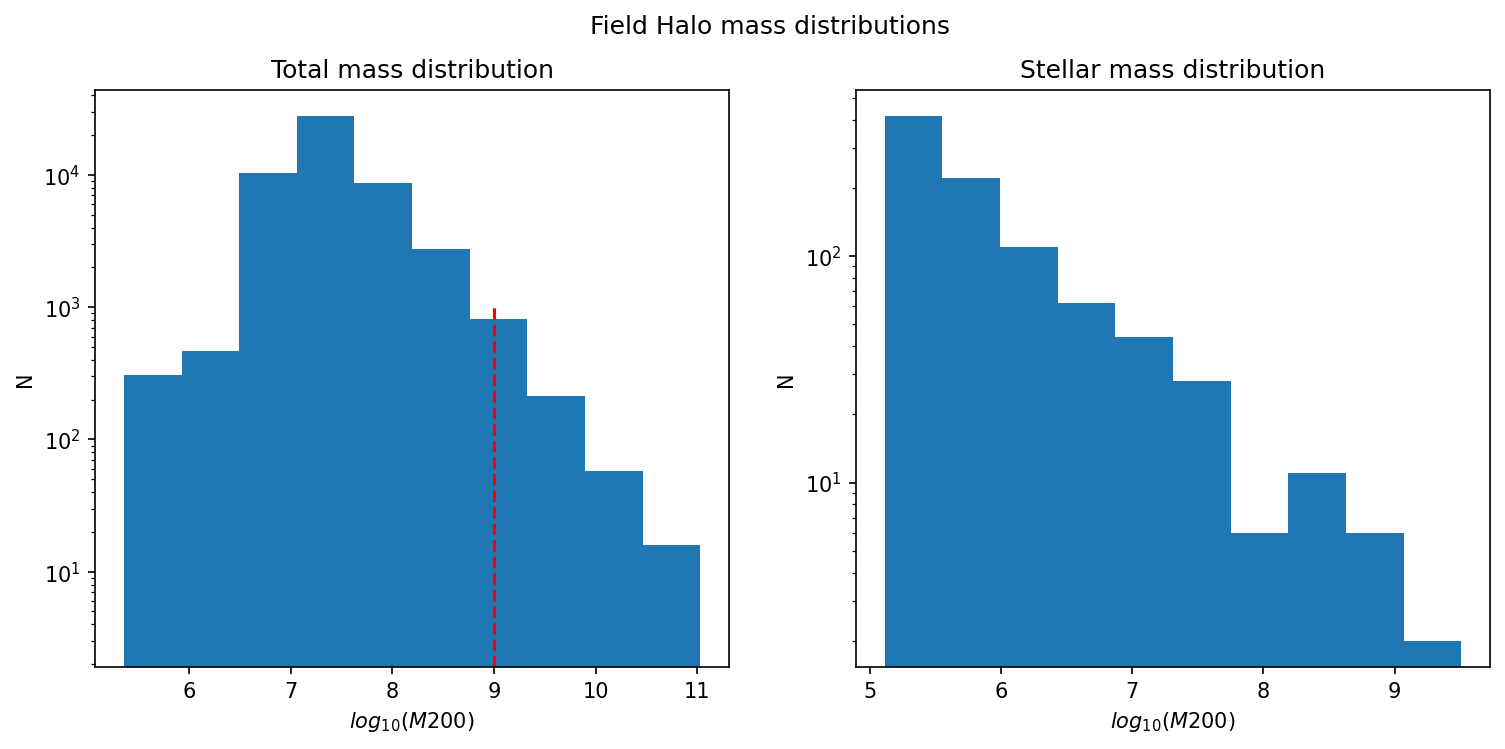

In [12]:
#vol15_sim.number_plots(distance_cut=True)
vol15_sim.plotFieldHaloMassDist()
#vol15_sim.plotStellarMassHaloMass_all()

C:\Users\prera\AppData\Local\Temp\ipykernel_8156\3628656824.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


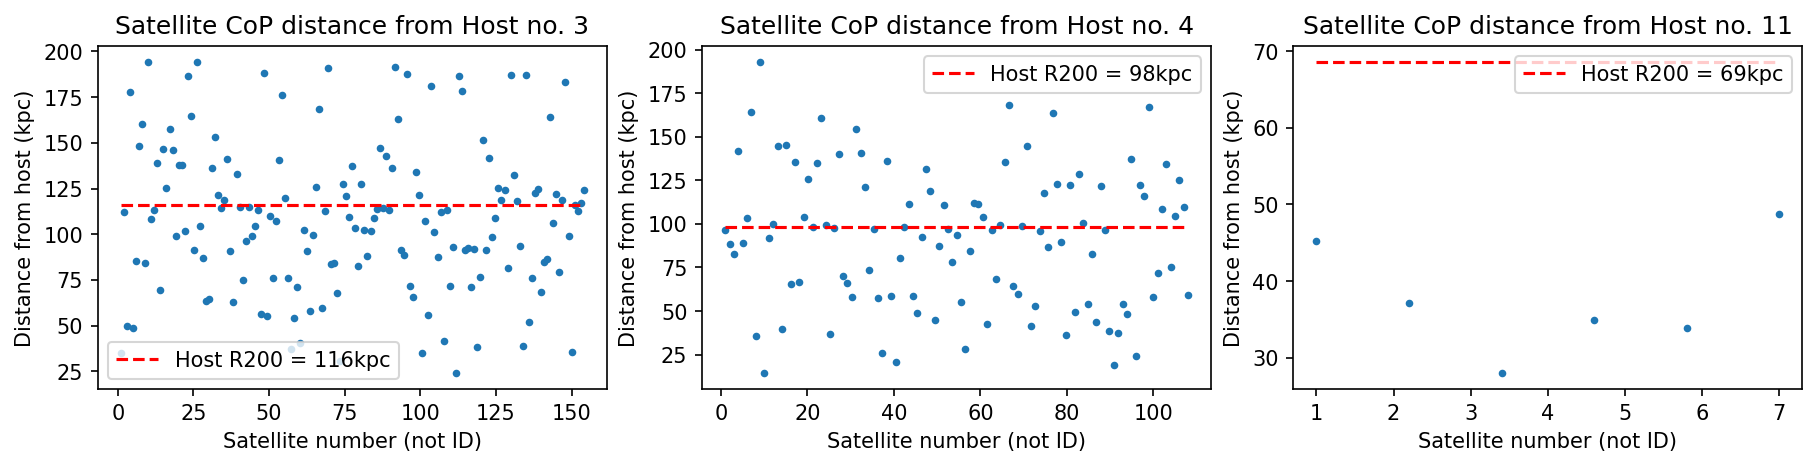

In [39]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
central_centers = np.array(vol15_df['Host CoM'])
for i, host_center in enumerate(central_centers):
    sat_centers = np.array(vol15_df['Sat CoM'].iloc[i])
    distances = np.array([np.linalg.norm(sat-host_center) for sat in sat_centers])*1000 #in kpc
    x = np.linspace(1, len(distances)+1, len(distances)) 
    ax_flat[i].scatter(x, distances, s = 7)
    r200 = vol15_df['Host R200'].iloc[i]
    ax_flat[i].hlines(r200, min(x), max(x), 'r', '--', label = f'Host R200 = {r200:.0f}kpc')
    ax_flat[i].set_xlabel('Satellite number (not ID)')
    ax_flat[i].set_ylabel('Distance from host (kpc)')
    host_id = vol15_df['Host ID'].iloc[i]
    ax_flat[i].set_title(f'Satellite CoP distance from Host no. {host_id}')
    ax_flat[i].legend()
fig.show()

C:\Users\prera\AppData\Local\Temp\ipykernel_8156\1754929835.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


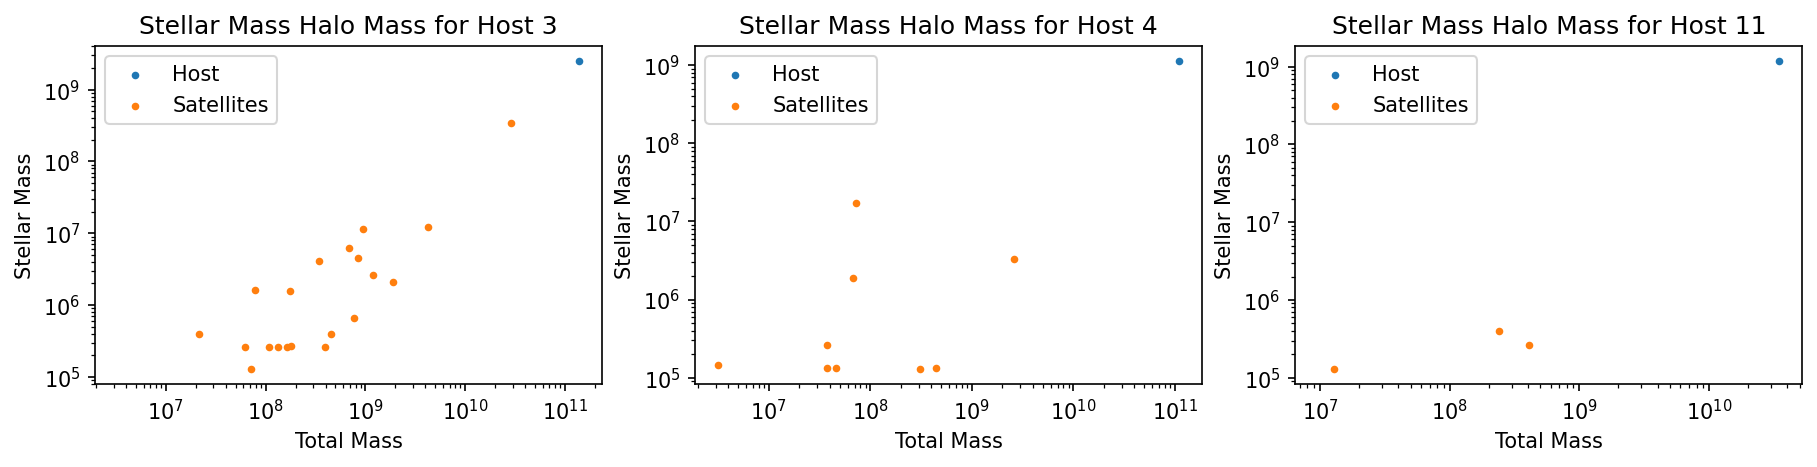

In [40]:
#make stellar mass hallo mass plots for each host and its respective satelites
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi=150, constrained_layout=True)
for i, a in enumerate(ax):
    a.scatter(vol15_df['Host Mtot'].iloc[i], vol15_df['Host M*'].iloc[i], s=7, label='Host')
    a.scatter(vol15_df['Sat Mtot'].iloc[i], vol15_df['Sat M*'].iloc[i], s=7, label='Satellites')
    a.set_xlabel('Total Mass')
    a.set_ylabel('Stellar Mass')
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend()
    host_id = vol15_df['Host ID'].iloc[i]
    a.set_title(f'Stellar Mass Halo Mass for Host {host_id}')
fig.show()
#combine all three in one plot to compare diff hosts